In [9]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [11]:
from tensorflow.keras import datasets

(X_tn0, y_tn0), (X_te0, y_te0) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [12]:
X_tn0.shape

(60000, 28, 28)

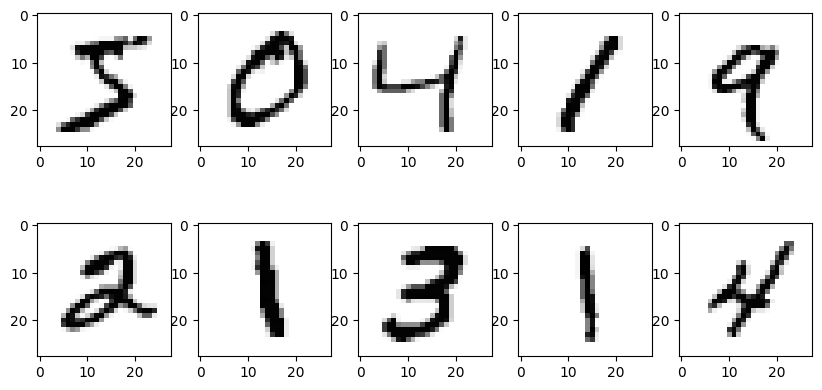

In [13]:
# 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn0[i].reshape((28, 28)),
               cmap='Greys')

plt.show()

In [15]:
# feature scale 조정
X_tn_re = X_tn0.reshape(60000, 28, 28, 1) # sample 수, 가로, 세로, 채널 수
X_tn = X_tn_re/255.0

print(X_tn.shape)

(60000, 28, 28, 1)


In [17]:
X_te_re = X_te0.reshape(10000, 28, 28, 1)
X_te = X_te_re/255.0


In [19]:
# 노이즈 데이터 생성
import numpy as np
X_tn_noise = X_tn + np.random.uniform(-1, 1, size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1, 1, size=X_te.shape)


In [21]:
# 노이즈 데이터 스케일링
# np.clip: 픽셀값이 0 이하: 0으로 변경, 1 이상: 1로 변경
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

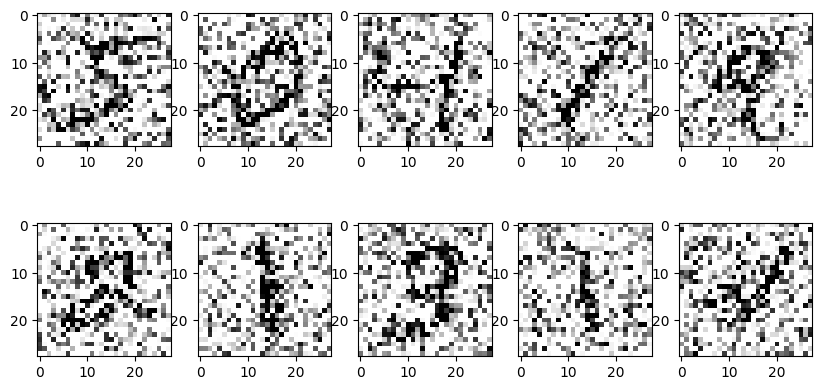

In [22]:
# 노이즈 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn_ns[i].reshape((28,28)),
               cmap='Greys')
plt.show()

In [25]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Activation


In [26]:
# 인코더
input_layer1 = Input(shape=(28,28,1))
x1 = Conv2D(20, kernel_size=(5,5),padding='same')(input_layer1)
x1 = Activation(activation='relu')(x1)
output_layer1 = MaxPooling2D(pool_size=2, padding='same')(x1)

encoder = Model(input_layer1, output_layer1)
encoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 20)        0         
 D)                                                              
                                                                 
Total params: 520 (2.03 KB)
Trainable params: 520 (2.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
output_layer1.shape

TensorShape([None, 14, 14, 20])

In [31]:
# 디코더

input_layer2 = Input(shape=output_layer1.shape[1:])
x2 = Conv2D(10, kernel_size=(5,5), padding='same')(input_layer2)
x2 = Activation(activation='relu')(x2)
x2 = UpSampling2D()(x2)
x2 = Conv2D(1,kernel_size=(5,5), padding='same')(x2)
output_layer2 = Activation(activation='relu')(x2)

decoder = Model(input_layer2, output_layer2)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 14, 20)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 10)        5010      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 10)        0         
                                                                 
 up_sampling2d (UpSampling2  (None, 28, 28, 10)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         251       
                                                                 
 activation_2 (Activation)   (None, 28, 28, 1)         0         
                                                           

In [33]:
# 오토인코더 생성

input_auto = Input(shape=(28,28,1))
output_auto = decoder(encoder(input_auto))

auto_encoder = Model(input_auto, output_auto)
auto_encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 14, 14, 20)        520       
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         5261      
                                                                 
Total params: 5781 (22.58 KB)
Trainable params: 5781 (22.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# 모형 컴파일
auto_encoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [40]:
# 학습
auto_encoder.fit(X_tn_ns, X_tn, epochs=1, batch_size=10)



6000/6000 [==============================] - 13s 2ms/step - loss: 0.0199 - mean_squared_error: 0.0199


In [41]:
X_pred = auto_encoder.predict(X_tn)

1875/1875 [==============================] - 3s 1ms/step


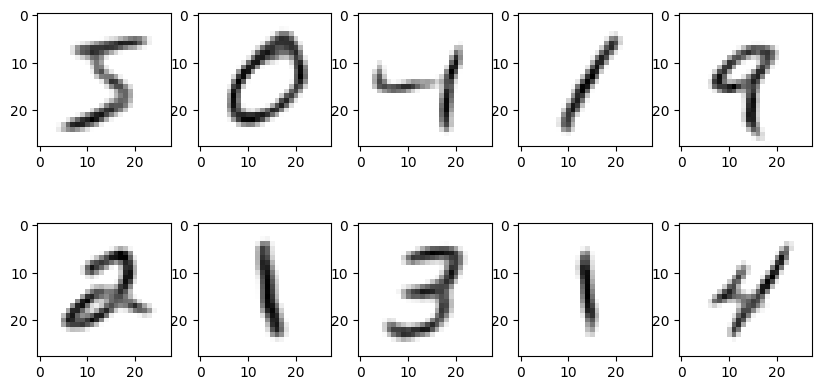

In [42]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_pred[i].reshape((28,28)),
               cmap='Greys')

plt.show()